---
format: 
  html:
    toc: true
    page-layout: full
execute:
    warning: false
    echo: true
    eval: true
---

# Prepare Machine Learning Data

The purpose of this section of the methodology is to examine the processed data, explore its structure, and perform additional processing to prepare the variables needed for machine learning models. The workflow merges all relevant variables into a single cohesive dataframe. By the end of the notebook, the output is a unified dataframe containing approximately 3,000 rows, each representing a census tract.

This notebook can be executed by loading the processed data from our GitHub repository. To reproduce our analysis, the following Python libraries are required: `pandas` for data manipulation, `geopandas` for handling spatial data, `numpy` for numerical operations, `shapely` for geometric analysis, and `libpysal` for spatial statistics and spatial data processing. Ensure that libpysal is installed to replicate our results accurately.

In [2]:
#| code-fold: true

import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import shape, Polygon, Point
from libpysal.weights import Queen
from libpysal.weights.spatial_lag import lag_spatial

## PA Geometry

In [3]:
#| echo: false
PA_Tracts = gpd.read_file('../data/PA_Tracts.geojson')

Let's first check the geometry of Pennsylvania's census tracts. After processing, the dataset is simplified to contain only two columns: GEOID and geometry. GEOID is useful when performing plain join to other variables while geometry will be useful when we compute nearest neighbor.

In [4]:
#| code-fold: true
PA_Tracts.head(3)

,GEOID,geometry
0,42001030101,"POLYGON ((-77.15558 40.05671, -77.15467 40.057..."
1,42001030103,"POLYGON ((-77.07256 39.97480, -77.07223 39.974..."
2,42001030104,"POLYGON ((-77.09913 39.94784, -77.09750 39.948..."


The plot below quickly visualizes census tracts in Pennsylvania. 

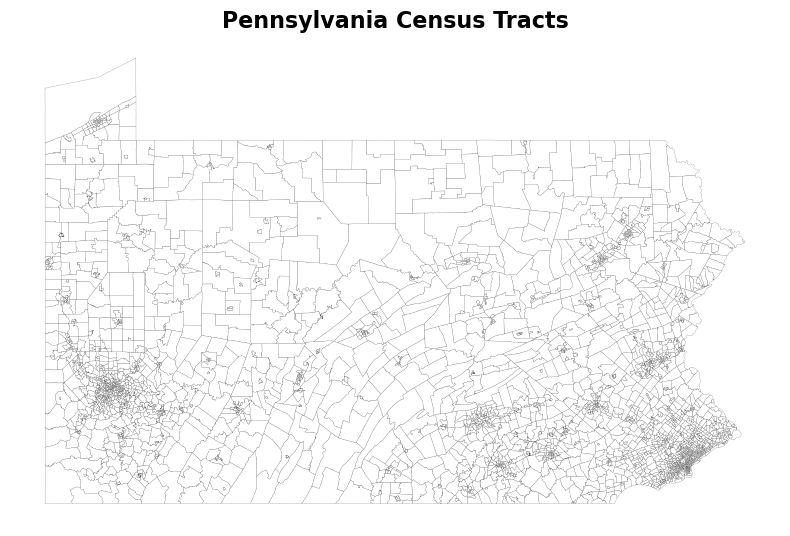

In [5]:
#| echo: false

fig, ax = plt.subplots(figsize=(8, 8))
PA_Tracts.plot(
    ax=ax,
    color='white',      # Fill color for geometries
    edgecolor='black',  # Border color for geometries
    linewidth=0.1       # Border line width
)

ax.set_title("Pennsylvania Census Tracts", fontsize=16, fontweight='bold')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()


## COPD Data and Health Risk Behaviors

In [7]:
#| echo: false
PA_Chronic = pd.read_csv('../data/PA_Chronic.csv')
PA_HRB = pd.read_csv('../data/PA_HRB.csv')
PA_Chronic = PA_Chronic[["CountyName", "LocationName", "Asthma", "TotalPopulation", "TotalPop18plus", "COP"]]
PA_HRB = PA_HRB[["CountyName", "LocationName", "Smoking", "Drinking", "Short_Sleep", "Physical_Activity"]]

Now, let's check both the COPD data and the health risks behavior data. After the cleaning process, the COPD dataset would only include 6 columns, among which we are mostly interested in LocationName (the GEOID) used to join it with other dataset as well as the prevalence of COPD. 

In [8]:
#| code-fold: true
PA_Chronic.head(3)

,CountyName,LocationName,Asthma,TotalPopulation,TotalPop18plus,COP
0,Allegheny,42003141200,9.7,4007,3242,4.8
1,Allegheny,42003140100,10.6,5579,5066,4.2
2,Allegheny,42003191900,10.6,2177,1786,5.9


A quick visualization of COPD prevalence in Pennsylvania reveals that urban areas such as Pittsburgh and Philadelphia experience higher COPD prevalence compare to the suburban area in its vincinity. However, several rural areas in Northern and Central Pennsylvania exhibit much higher rate of COPD. 

In [21]:
#| echo: false
PA_Tracts['GEOID'] = PA_Tracts['GEOID'].astype(str)
PA_Chronic['LocationName'] = PA_Chronic['LocationName'].astype(str)
PA_Tracts_Plot = PA_Tracts.merge(PA_Chronic, left_on='GEOID', right_on='LocationName', how='left')

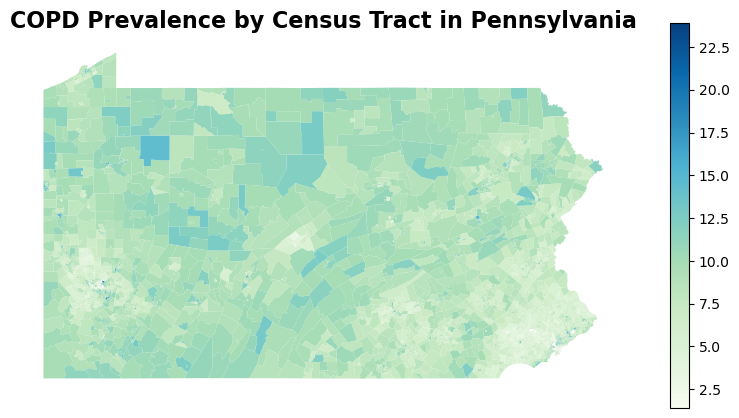

In [10]:
#| echo: false
fig, ax = plt.subplots(figsize=(8, 8))
PA_Tracts_Plot.plot(column='COP', cmap='GnBu', linewidth=0, edgecolor=None, ax=ax, legend=True, legend_kwds={'shrink': 0.5, 'orientation': 'vertical'})

ax.set_title("COPD Prevalence by Census Tract in Pennsylvania", fontsize=16, fontweight='bold')

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [11]:
#| echo: false
county_summary = PA_Chronic.groupby('CountyName')['COP'].mean().reset_index()
county_summary = county_summary.sort_values(by='COP', ascending=False)

Indeed, if we look at the top 10 counties in Pennsylvania with highest average COPD prevalence, we many notice that these are not urban counties. They are also not proximate to any urban areas. Cameron, Mifflin, Forest, and Sullivan counties are both located in central Pennsylvania. This is a pretty surprising observation as researchers often assume people living in urban areas to be more vulnerable to COPD because of air pollution, development density, etc.

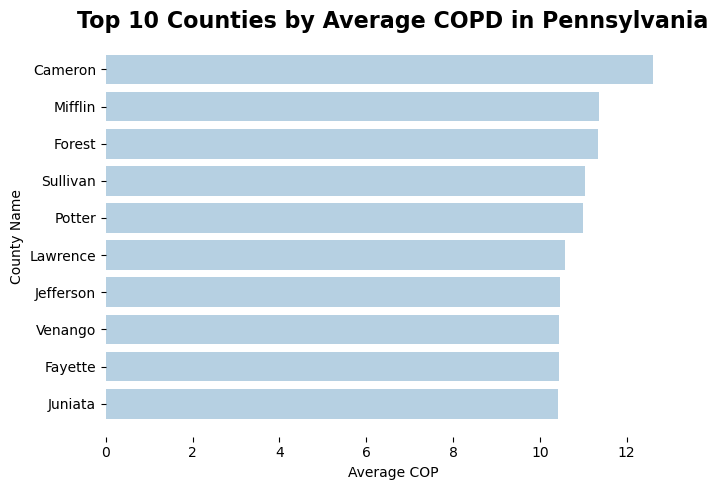

In [196]:
#| echo: false

top_10_counties = county_summary.sort_values(by='COP', ascending=False).head(10)
plt.figure(figsize=(7, 5))
plt.barh(top_10_counties['CountyName'], top_10_counties['COP'], color="#B6D0E2")
plt.xlabel('Average COP')
plt.ylabel('County Name')
plt.title('Top 10 Counties by Average COPD in Pennsylvania', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest values at the top

# Remove the box around the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.tight_layout()
plt.show()

The health risks behavior dataset includes only 6 variables as well, which are mainly the percentages of population who smoke and drink on a regular basis and having short sleep, no physical activity. 

In [12]:
#| code-fold: true
PA_HRB.head(3)

,CountyName,LocationName,Smoking,Drinking,Short_Sleep,Physical_Activity
0,Adams,42001030300,17.7,18.2,39.6,25.4
1,Allegheny,42003151700,15.2,21.2,34.8,20.8
2,Allegheny,42003151600,17.1,21.7,35.1,21.8


## Tobacco Retailer Data

In [13]:
#| echo: false

PA_Retailers = pd.read_csv('../data/PA_Retailers.csv')

After loading in the retailers data `PA_Retailers`, we need to create a new column geometry by applying a lambda function to each row. The lambda function constructs a Point object using the longitude (lon) and latitude (lat) values from each row. The next piece of code convert the `PA_Retailers` DataFrame into a GeoDataFrame, specifying the geometry column and setting the coordinate reference system (CRS) to EPSG:4326.

In [15]:
# make retailer data spatial
PA_Retailers['geometry'] = PA_Retailers.apply(
    lambda row: Point(row['lon'], row['lat']), axis=1
)
PA_Retailers = gpd.GeoDataFrame(
    PA_Retailers,
    geometry='geometry',
    crs='EPSG:4326'
)

We included here a quick visualization of the distribution of tobacco retailers in Pennsylvania. 

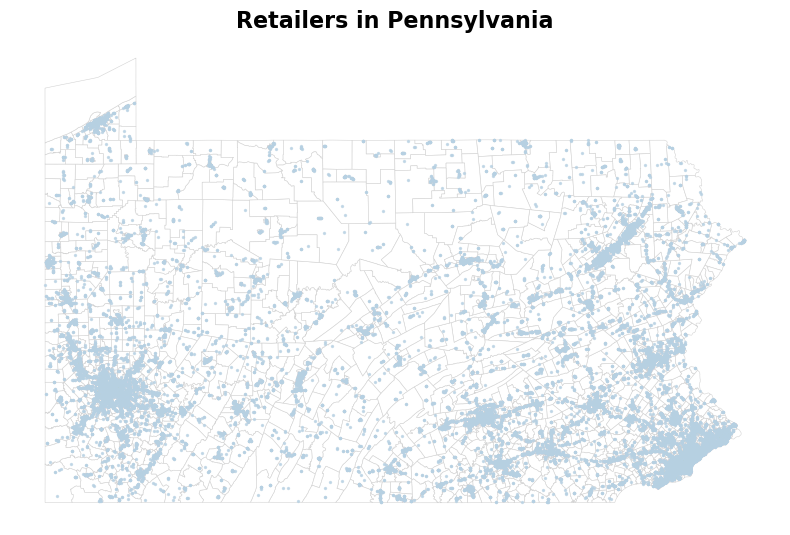

In [16]:
#| echo: false
fig, ax = plt.subplots(figsize=(8, 8))

PA_Tracts.plot(ax=ax, color='white', edgecolor="lightgrey", linewidth=0.4)
PA_Retailers.plot(ax=ax, markersize=2, alpha=0.7, label='Retailers', marker='o', color = "#B6D0E2")

ax.set_title("Retailers in Pennsylvania", fontsize=16, fontweight='bold')

ax.set_axis_off()
plt.tight_layout()
plt.show()

Since in the introduction, we've mentioned that we would like to account for environment exposures to tobacco retailers  from neighboring tracts considering that people travel between different tracts everyday, there's some extrat steps we need to do to compute retailer density and average them across it neighbors. The code below first performs a spatial join between `PA_Tracts` and `PA_Retailers`, joining the two GeoDataFrames based on their spatial relationship. The how="left" parameter ensures that all tracts are retained, and the predicate="intersects" parameter specifies that retailers intersecting with tracts should be joined. Then, we need to summarize the total retailers in each tract, and merge the summary beack to the original `PA_Tracts` GeoDataFrame. Any tracts without retailers are filled with a count of zero. To compute density, we also need to convert our GeoDataFrame to EPSG:3857 for more accurate area calculations. Then, the density of retailers is calcualted through dividing the total number of retailers by the area of the tract.

In [17]:
# count retailers
tracts_with_retailers = gpd.sjoin(PA_Tracts, PA_Retailers, how="left", predicate="intersects")
tracts_summary = (
    tracts_with_retailers.groupby("GEOID")
    .size()
    .reset_index(name="total_retailers")
)

tracts_with_retailers= PA_Tracts.merge(tracts_summary, on="GEOID", how="left")
tracts_with_retailers["total_retailers"] = tracts_with_retailers["total_retailers"].fillna(0)

# compute density
density = tracts_with_retailers.to_crs(epsg=3857)
density['area_km2'] = density.geometry.area / 1e6  # Convert m² to km²
density ['density'] = density ['total_retailers'] / density ['area_km2']

To know the average density across neighboring tracts, a spatial weights matrix is created based on the geometries of tracts using the Queen contiguity method, which considers tracts as neighbors if they share a boundary or a vertex. This is done with the `Queen.from_dataframe(density)` function. Next, it computes the average density of neighboring tracts by applying the `lag_spatial` function, which uses the spatial weights matrix to calculate the spatial lag of the density column, resulting in a new column neighbor_avg_density in the density GeoDataFrame. Finally, the code removes the area_km2 column from the density GeoDataFrame, renaming it to `PA_Retailers`.

In [18]:
# Create spatial weights matrix based on tract geometries
weights = Queen.from_dataframe(density)

# Compute average density of neighbors using lag_spatial
density['neighbor_avg_density'] = lag_spatial(
    weights, density['density']
)
PA_Retailers = density.drop(columns=["area_km2"])

/var/folders/44/6sj4ffx97_xdwpmwfbt4jbpc0000gn/T/ipykernel_14947/3380817085.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  weights = Queen.from_dataframe(density)


The final `PA_Retailers` dataset would only include the following columns in addition to GEOID and the geometry: total retailers of a census tract, retailer density, as well as the average density across its neighboring tracts. 

In [188]:
#| code-fold: true
PA_Retailers.head(5)

,GEOID,geometry,total_retailers,density,neighbor_avg_density
0,42001030101,"POLYGON ((-8588920.357 4874186.492, -8588818.5...",3,0.031552,0.227339
1,42001030103,"POLYGON ((-8579678.266 4862280.523, -8579641.3...",1,0.031470,0.158547
2,42001030104,"POLYGON ((-8582635.361 4858365.994, -8582454.6...",7,0.081237,1.671000
3,42001030200,"POLYGON ((-8599802.938 4869004.417, -8599007.8...",8,0.038641,0.413897
4,42001030300,"POLYGON ((-8618506.453 4863224.423, -8618215.5...",5,0.026165,0.216389


The visualization of average tobacco retailer density across neighboring census tract is not very exciting, as expected, since most of the retailers are located in urban areas. Except for Philadelphia and Pittsburgh, where the density of tobacco retailer is high, most rurual areas in Pennsylvania has a low tobacco retailer density. This suggets that exposure to tobacco retailer store might not have a significant effect to explain the high COPD in central and northern Pennsylvania.

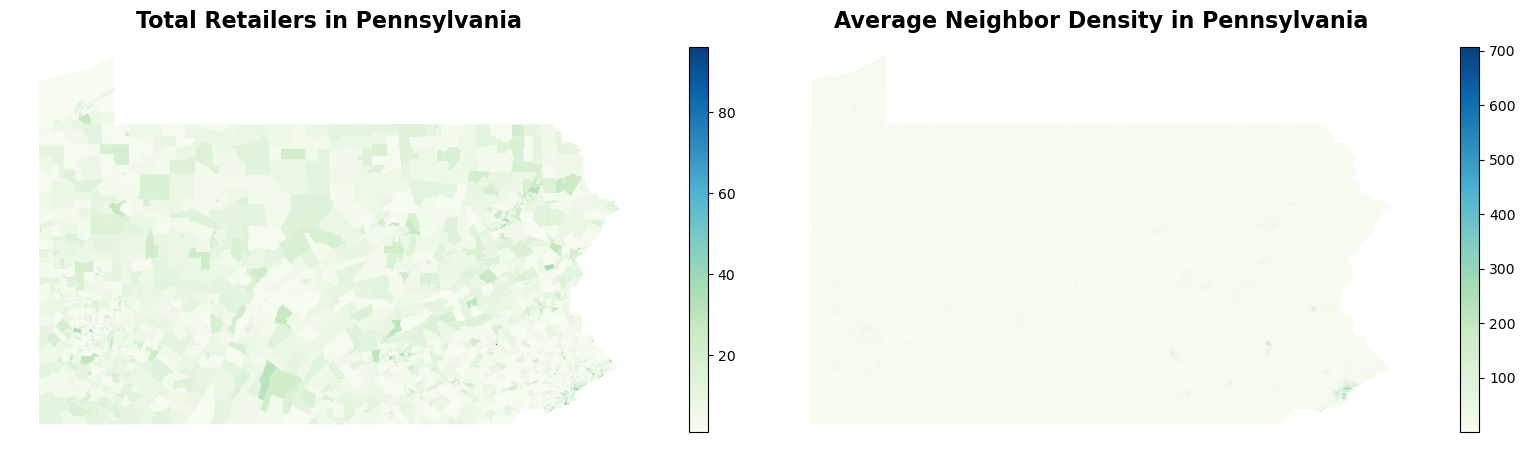

In [195]:
#| echo: false

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot total_retailers
PA_Retailers.plot(column='total_retailers', cmap='GnBu', linewidth=0, edgecolor=None, ax=axes[0], legend=True, legend_kwds={'shrink': 0.5, 'orientation': 'vertical'})
axes[0].set_axis_off()
axes[0].set_title("Total Retailers in Pennsylvania", fontsize=16, fontweight='bold')

# Plot neighbor_avg_density
PA_Retailers.plot(column='neighbor_avg_density', cmap='GnBu', linewidth=0, edgecolor=None, ax=axes[1], legend=True, legend_kwds={'shrink': 0.5, 'orientation': 'vertical'})
axes[1].set_axis_off()
axes[1].set_title("Average Neighbor Density in Pennsylvania", fontsize=16, fontweight='bold')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

## Census Data

In [19]:
#| echo: false
PA_Census = pd.read_csv('../data/PA_Census_Data.csv')

Now, let's take a look at the census data. The processed dataset only contains the predictors we will use in machine leanring models: percentage of minority, aging and disability population. 

In [20]:
#| code-fold: true
PA_Census.head(3)

,GEOID,minority,aging,disability,geometry
0,42125775200,0.211840,0.215264,0.287671,"POLYGON ((-79.876586 40.177549, -79.876234 40...."
1,42125775300,0.395709,0.131506,0.273739,"POLYGON ((-79.879294 40.174857, -79.878454 40...."
2,42125782700,0.048652,0.314267,0.302433,"POLYGON ((-79.913564 40.153257, -79.913332 40...."


For population with disability (as well as aging population, though not plotted), the spatial pattern is not that apparent. However, for racial minority population, it is definitely more concentrated in urban areas (Philadelphia and Pittsburgh). Meanwhile, some census tracts in northeastern and central Pennsylvania also exhibit more diversity in racial composition. 

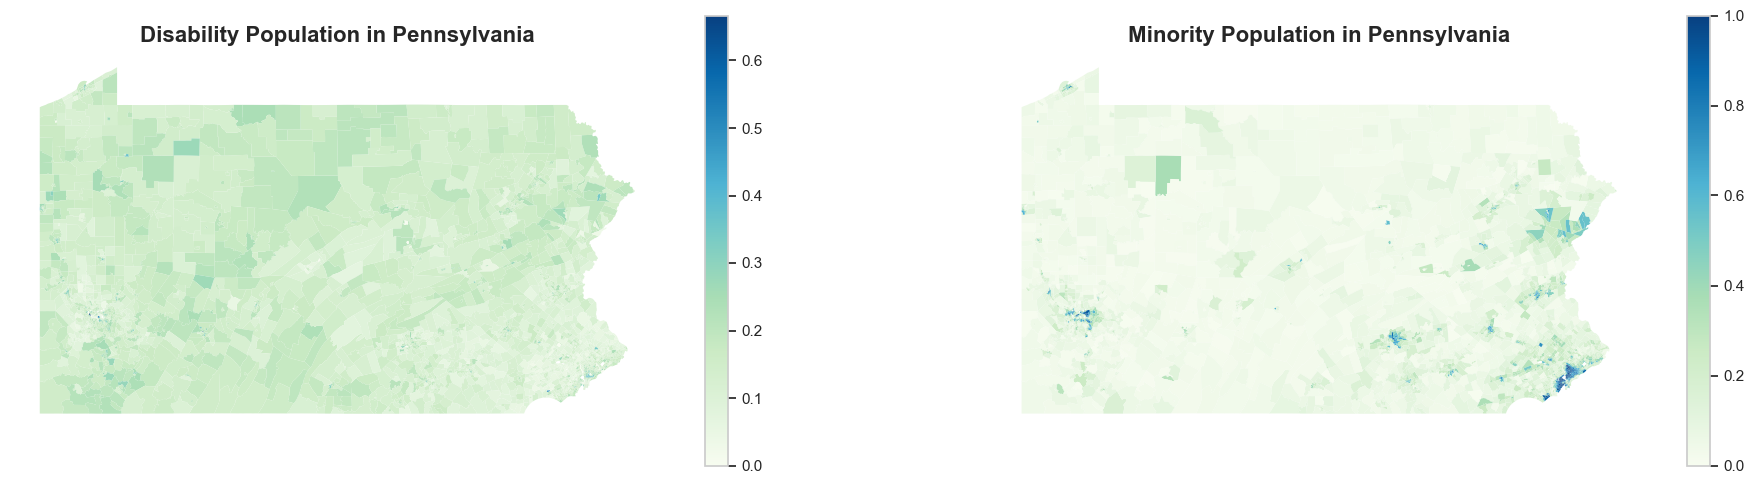

In [38]:
#| echo: false

import seaborn as sns
import matplotlib.pyplot as plt

PA_Census['GEOID'] = PA_Census['GEOID'].astype(str)
PA_Tracts_Plot2 = PA_Tracts.merge(PA_Census[["GEOID", "minority", "aging", "disability"]], on='GEOID', how='left')

def plot_two_variables():
    # Create a 1x2 grid of plots (side by side)
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    variables = ['disability', 'minority']
    
    for i, column in enumerate(variables):
        ax = axes[i]
        sns.set(style="whitegrid")
        PA_Tracts_Plot2.plot(
            column=column,
            cmap='GnBu',
            linewidth=0,
            edgecolor=None,
            ax=ax,
            legend=True,
            legend_kwds={'shrink': 0.5, 'orientation': 'vertical'}
        )
        ax.set_axis_off()
        ax.set_title(f"{column.capitalize()} Population in Pennsylvania", fontsize=16, fontweight='bold')
    
    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
    plt.show()

plot_two_variables()



## Land Cover Data

In [42]:
#| echo: false

# read land cover data
folder_path = '../data/PA_Landcover/'

csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

landcover = []
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    first_word = file.split()[0]
    df = pd.read_csv(file_path)
    df['source_file'] = first_word
    df = df.drop(columns=["system:index", ".geo"])
    landcover.append(df)


Let's load in all of our land cover data. There are six of them in total representing different land cover groups: forest, grasses, high density development, low density development, water and wetland. Below is an example of the forest land cover dataset that contains four columns. In addition to the GEOID and the file name identifier, it includes the total forest pixels and number of contiguous forest pixels in each census tract.

In [43]:
#| code-fold: true
landcover[1].head(3)

,geoid,neighbor_landcover,total_landcover,source_file
0,42001030101,6885.043137,14626.749020,forest_landcover_metrics.csv
1,42001030103,2053.384314,5035.964706,forest_landcover_metrics.csv
2,42001030104,3582.129412,10099.086275,forest_landcover_metrics.csv


The code below demonstrates the process of merging multiple landcover datasets based on a common key (geoid), and then performing a series of transformations to organize and compute relevant landcover metrics. The code begins by merging the first dataset `landcover[0]` with the next dataset `landcover[1]` using a left join on the geoid column. This ensures that the resulting `merged_df` contains all rows from the first dataset, along with matching rows from the second dataset. The columns are then renamed to more meaningful names like forest_total, forest_neighbor, and grasses_total. Unnecessary are dropped to clean up the data. The process of merging, renaming, and dropping columns is repeated for several additional datasets (`landcover[2]` to `landcover[5]`), progressively adding landcover data related to wetlands, water, and development density. 

In [44]:
#| code-fold: true

# combine landcover data
merged_df= pd.merge(landcover[0], landcover[1], on="geoid", how="left")
merged_df = merged_df.rename(
    columns={
        "total_landcover": "forest_total",
        "neighbor_landcover": "forest_neighbor",
        "sum": "grasses_total",
    }
)
merged_df = merged_df.drop(columns=["source_file_x", "source_file_y"])
merged_df = pd.merge(merged_df, landcover[2], on="geoid", how="left")
merged_df = merged_df.rename(
    columns={
        "sum": "wetland_total",}
)
merged_df = merged_df.drop(columns=["source_file"])
merged_df = pd.merge(merged_df, landcover[3], on="geoid", how="left")
merged_df = merged_df.rename(
    columns={
        "sum": "water_total"    }
)
merged_df = merged_df.drop(columns=["source_file"])
merged_df = pd.merge(merged_df, landcover[4], on="geoid", how="left")
merged_df = merged_df.rename(
    columns={
        "sum": "Ldensity_total"    }
)
merged_df = merged_df.drop(columns=["source_file"])
merged_df = pd.merge(merged_df, landcover[5], on="geoid", how="left")
merged_df = merged_df.rename(
    columns={
        "total_landcover": "Hdensity_total",
        "neighbor_landcover": "Hdensity_neighbor",    }
)
PA_Landcover = merged_df.drop(columns=["source_file"])

# some metrics with landcover data
PA_Landcover['forest_pct'] = PA_Landcover['forest_neighbor'] / PA_Landcover['forest_total']
PA_Landcover['Hdensity_pct'] = PA_Landcover['Hdensity_neighbor'] / PA_Landcover['Hdensity_total']
PA_Landcover = PA_Landcover.drop(columns=["forest_neighbor", "Hdensity_neighbor"])

The final dataset would look like the following: 

In [45]:
#| code-fold: true

PA_Landcover.head(3)

,geoid,grasses_total,forest_total,wetland_total,water_total,Ldensity_total,Hdensity_total,forest_pct,Hdensity_pct
0,42001030101,31291.925490,14626.749020,2675.717647,288.745098,5868.972549,817.870588,0.470716,0.084107
1,42001030103,11254.184314,5035.964706,408.607843,879.866667,3644.113725,283.894118,0.407744,0.042269
2,42001030104,40245.227451,10099.086275,2142.858824,405.870588,6041.019608,1041.843137,0.354698,0.032345


We could also visualize the spatial distribution of the aggregated number of pixels for each kind of land cover in Pennsylvania. We may see that grasslands and forests are mainly concentrated in central and northern Pennsylvania. Welands are mainly concentrated in western Pennsylvania. Eastern Pennsylvania has more high density development than the western part.

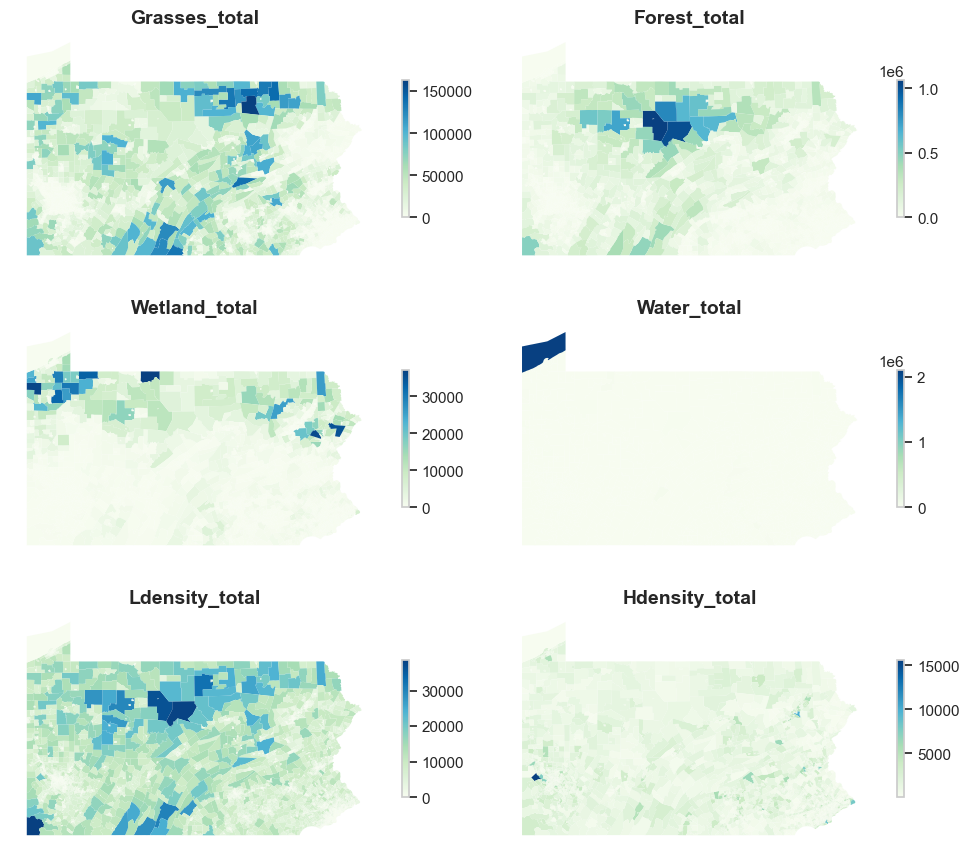

In [55]:
#| echo: false

PA_Landcover['GEOID'] = PA_Landcover['geoid'].astype(str)
PA_Tracts_Plot3 = PA_Tracts.merge(PA_Landcover, on='GEOID', how='left')

columns_to_plot = ['grasses_total', 'forest_total', 'wetland_total', 'water_total', 'Ldensity_total', 'Hdensity_total']

num_plots = len(columns_to_plot)
num_cols = 2  #
num_rows = num_plots // num_cols + (1 if num_plots % num_cols != 0 else 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 9))
if num_rows > 1:
    axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    row_index = i // num_cols
    col_index = i % num_cols
    PA_Tracts_Plot3.plot(column=column, cmap='GnBu', linewidth=0, edgecolor=None, ax=axes[i], legend=True, legend_kwds={'shrink': 0.5, 'orientation': 'vertical'})
    
 
    axes[i].set_title(f'{column.capitalize()}', fontsize=14, fontweight='bold')
    axes[i].set_axis_off()

for i in range(num_plots, num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


## Landsat Data

In [57]:
#| echo: false

# read in landsat data
folder_path = '../data/PA_Landsat/'

csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

landsat = []
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    first_word = file.split()[0]
    df = pd.read_csv(file_path)
    df['source_file'] = first_word
    df = df.drop(columns=["system:index", ".geo"])
    landsat.append(df)

The folder that stores Landsat data contains 16 files, with 4 vegetation indices for 4 seasons. Each of them is an individual file. Below is an example of one of the files. It only has three column, in which mean refers to the mean of savi in fall for each census tract. 

In [61]:
#| code-fold: true

landsat[0].head(3)

,GEOID,mean,source_file
0,42001030101,0.395006,savi_fall.csv
1,42001030103,0.341787,savi_fall.csv
2,42001030104,0.359570,savi_fall.csv


We need to perform the same operation as above to merge all 16 files together. The process starts by merging the first two datasets in the landsat list using a left join on `GEOID`, and it renames the relevant columns for clarity, specifically renaming the columns representing different vegetation indices (e.g., savi_fall, lst_summer). Unnecessary columns are then dropped to clean up the data. This merging and renaming process is repeated for additional datasets in the landsat list (from `landsat[2]` to `landsat[15]`), progressively adding columns related to different vegetation indices (e.g., evi_spring, lst_winter, ndvi_summer) for various seasons (spring, summer, fall, winter). Once all the datasets are merged, the final dataframe, `PA_Landsat`, contains a comprehensive set of vegetation index data for different seasons.

In [59]:
#| code-fold: true

# combine landsat data
merged_df2= pd.merge(landsat[0], landsat[1], on="GEOID", how="left")
merged_df2 = merged_df2.rename(
    columns={
        "mean_x": "savi_fall",
        "mean_y": "lst_summer",
    }
)
merged_df2 = merged_df2.drop(columns=["source_file_x", "source_file_y"])
merged_df2 = pd.merge(merged_df2, landsat[2], on="GEOID", how="left")
merged_df2 = merged_df2.rename(
    columns={
        "mean": "evi_spring",
    }
)
merged_df2 = merged_df2.drop(columns=["source_file"])
merged_df2 = pd.merge(merged_df2, landsat[3], on="GEOID", how="left")
merged_df2 = merged_df2.rename(
    columns={
        "mean": "evi_winter",
    }
)
merged_df2 = merged_df2.drop(columns=["source_file"])
merged_df2 = pd.merge(merged_df2, landsat[4], on="GEOID", how="left")
merged_df2 = merged_df2.rename(
    columns={
        "mean": "evi_summer",
    }
)
merged_df2 = merged_df2.drop(columns=["source_file"])
merged_df2 = pd.merge(merged_df2, landsat[5], on="GEOID", how="left")
merged_df2 = merged_df2.rename(
    columns={
        "mean": "lst_spring",
    }
)
merged_df2 = merged_df2.drop(columns=["source_file"])
merged_df2 = pd.merge(merged_df2, landsat[6], on="GEOID", how="left")
merged_df2 = merged_df2.rename(
    columns={
        "mean": "evi_fall",
    }
)
merged_df2 = merged_df2.drop(columns=["source_file"])
merged_df2 = pd.merge(merged_df2, landsat[7], on="GEOID", how="left")
merged_df2 = merged_df2.rename(
    columns={
        "mean": "lst_winter",
    }
)
merged_df2 = merged_df2.drop(columns=["source_file"])
merged_df2 = pd.merge(merged_df2, landsat[8], on="GEOID", how="left")
merged_df2 = merged_df2.rename(
    columns={
        "mean": "ndvi_summer",
    }
)
merged_df2 = merged_df2.drop(columns=["source_file"])
merged_df2 = pd.merge(merged_df2, landsat[9], on="GEOID", how="left")
merged_df2 = merged_df2.rename(
    columns={
        "mean": "savi_spring",
    }
)
merged_df2 = merged_df2.drop(columns=["source_file"])
merged_df2 = pd.merge(merged_df2, landsat[10], on="GEOID", how="left")
merged_df2 = merged_df2.rename(
    columns={
        "mean": "lst_fall",
    }
)
merged_df2 = merged_df2.drop(columns=["source_file"])
merged_df2 = pd.merge(merged_df2, landsat[11], on="GEOID", how="left")
merged_df2 = merged_df2.rename(
    columns={
        "mean": "savi_winter",
    }
)
merged_df2 = merged_df2.drop(columns=["source_file"])
merged_df2 = pd.merge(merged_df2, landsat[12], on="GEOID", how="left")
merged_df2 = merged_df2.rename(
    columns={
        "mean": "savi_summer",
    }
)
merged_df2 = merged_df2.drop(columns=["source_file"])
merged_df2 = pd.merge(merged_df2, landsat[13], on="GEOID", how="left")
merged_df2 = merged_df2.rename(
    columns={
        "mean": "ndvi_winter",
    }
)
merged_df2 = merged_df2.drop(columns=["source_file"])
merged_df2 = pd.merge(merged_df2, landsat[14], on="GEOID", how="left")
merged_df2 = merged_df2.rename(
    columns={
        "mean": "ndvi_fall",
    }
)
merged_df2 = merged_df2.drop(columns=["source_file"])
merged_df2 = pd.merge(merged_df2, landsat[15], on="GEOID", how="left")
merged_df2 = merged_df2.rename(
    columns={
        "mean": "ndvi_spring",
    }
)
PA_Landsat = merged_df2.drop(columns=["source_file"])

Let's check the output of the merge. 

In [60]:
#| code-fold: true

PA_Landsat.head(3)

,GEOID,savi_fall,lst_summer,evi_spring,evi_winter,evi_summer,lst_spring,evi_fall,lst_winter,ndvi_summer,savi_spring,lst_fall,savi_winter,savi_summer,ndvi_winter,ndvi_fall,ndvi_spring
0,42001030101,0.395006,33.257296,0.319802,0.260378,0.568514,10.827598,0.410165,4.714395,0.762120,0.316083,19.379386,0.263375,0.517445,0.473559,0.672438,0.501817
1,42001030103,0.341787,33.251842,0.291822,0.238932,0.537638,9.268735,0.349453,4.470871,0.736301,0.288043,19.461976,0.241329,0.491634,0.434709,0.620192,0.470976
2,42001030104,0.359570,33.716166,0.337012,0.280906,0.563929,10.559965,0.368580,4.283530,0.753435,0.328228,19.039489,0.279969,0.512783,0.468789,0.616475,0.509266


We could also visualize all the variables we have. Taking into the account the influence of seasonality is an important decision for more accurate prediction of COPD prevalence given that vegetation indices would change significant depending on the season should there be a correlation between them and COPD prevalence. In addition, spatial variations in vegetation indices across Pennsylvania is also evident in this map. 

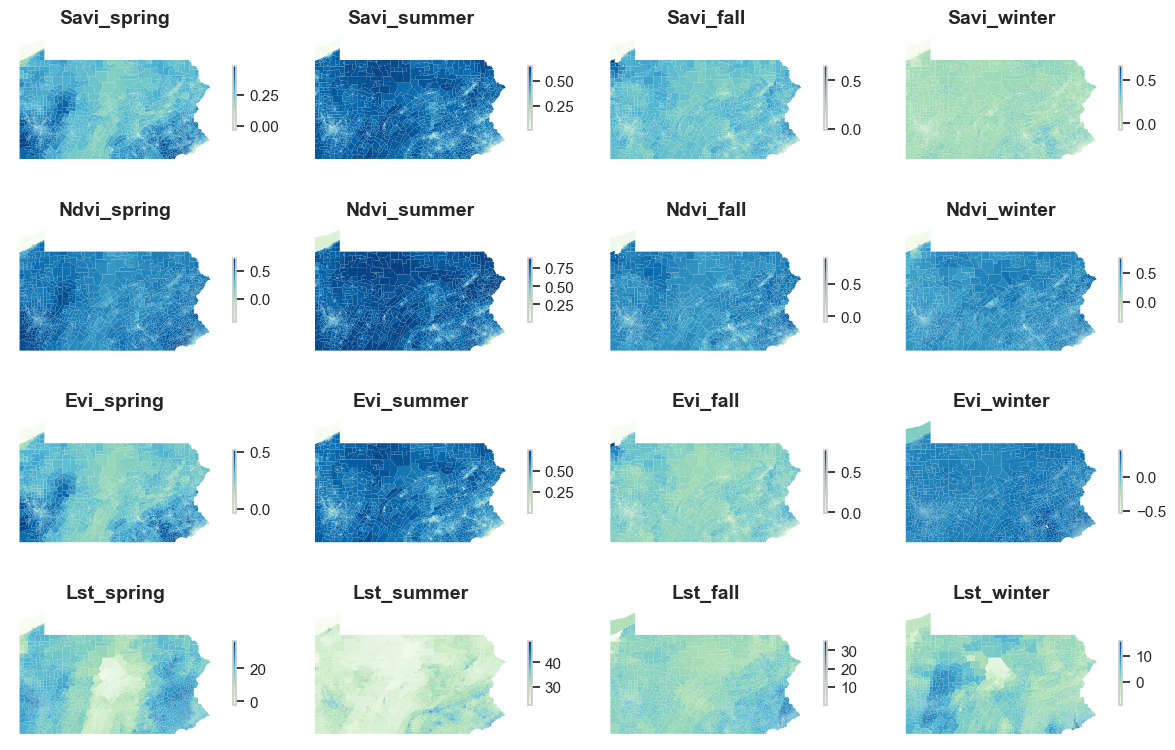

In [77]:
#| echo: false

PA_Landsat['GEOID'] = PA_Landsat['GEOID'].astype(str)
PA_Tracts_Plot4 = PA_Tracts.merge(PA_Landsat, on='GEOID', how='left')
columns_to_plot = ['savi_spring', 'savi_summer', 'savi_fall', 'savi_winter', 'ndvi_spring', 'ndvi_summer', 'ndvi_fall', 'ndvi_winter', 'evi_spring', 'evi_summer', 'evi_fall', 'evi_winter', 'lst_spring', 'lst_summer', 'lst_fall', 'lst_winter']

num_plots = len(columns_to_plot)
num_cols = 4  
num_rows = num_plots // num_cols + (1 if num_plots % num_cols != 0 else 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
if num_rows > 1:
    axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    row_index = i // num_cols
    col_index = i % num_cols
    PA_Tracts_Plot4.plot(column=column, cmap='GnBu', linewidth=0, edgecolor=None, ax=axes[i], legend=True, legend_kwds={'shrink': 0.35, 'orientation': 'vertical'})
    
 
    axes[i].set_title(f'{column.capitalize()}', fontsize=14, fontweight='bold')
    axes[i].set_axis_off()

for i in range(num_plots, num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

## Merging All Data

The very last step in preparing our dataframe for machine learning is to merge all dataframes together. The `GEOID` column in each dataset is explicitly converted to a string type to ensure consistency in the merging process. The datasets include information about chronic disease statistics `from PA_Chronic`, health risk behaviors from `PA_HRB`, retailer density from `PA_Retailers`, demographic factors from `PA_Census`, landcover from `PA_Landcover`, and satellite imagery data `from PA_Landsat`. The purpose of these merges is to create a comprehensive dataset, `PA_Final`, which combines relevant health, demographic, environmental, and spatial factors for each geographic area (defined by GEOID). This combined dataset will be useful for analyzing spatial relationships between chronic health conditions, environmental factors, and socio-economic characteristics, enabling more targeted health interventions and spatial analysis in Pennsylvania. Additionally, missing values in the final dataset are filled with zeros (fillna(0)),

In [86]:
#| code-fold: true

# everthing combined
PA_Retailers['GEOID'] = PA_Retailers['GEOID'].astype(str)
PA_Landsat['GEOID'] = PA_Landsat['GEOID'].astype(str)
PA_Landcover['GEOID'] = PA_Landcover['geoid'].astype(str)
PA_Census['GEOID'] = PA_Census['GEOID'].astype(str)
PA_Chronic['GEOID'] = PA_Chronic['LocationName'].astype(str)
PA_HRB['GEOID'] = PA_HRB['LocationName'].astype(str)

PA_Final = pd.merge(PA_Chronic, PA_HRB[["GEOID", "Smoking", "Drinking", "Short_Sleep", "Physical_Activity"]], on="GEOID", how="inner")
PA_Final = pd.merge(PA_Final, PA_Retailers[["GEOID", "neighbor_avg_density"]],  on="GEOID", how="inner")
PA_Final = pd.merge(PA_Final, PA_Census[["GEOID", "minority", "aging", "disability"]],  on="GEOID", how="inner")
PA_Final = pd.merge(PA_Final, PA_Landcover.drop(columns=["geoid"]),  on="GEOID", how="inner")
PA_Final = pd.merge(PA_Final, PA_Landsat,  on="GEOID", how="inner")
PA_Final = PA_Final.fillna(0)

Below is a snap shot of the final dataframe.

In [87]:
#| code-fold: true

PA_Final.head(5)

,CountyName,LocationName,Asthma,TotalPopulation,TotalPop18plus,COP,GEOID,Smoking,Drinking,Short_Sleep,...,evi_fall,lst_winter,ndvi_summer,savi_spring,lst_fall,savi_winter,savi_summer,ndvi_winter,ndvi_fall,ndvi_spring
0,Allegheny,42003141200,9.7,4007,3242,4.8,42003141200,10.3,21.3,32.1,...,0.254667,5.846844,0.569421,0.274674,23.110598,0.126746,0.342207,0.316698,0.485495,0.469827
1,Allegheny,42003140100,10.6,5579,5066,4.2,42003140100,10.7,23.9,34.5,...,0.299216,6.916926,0.570255,0.297535,21.461009,0.155348,0.365760,0.347601,0.512010,0.488617
2,Allegheny,42003191900,10.6,2177,1786,5.9,42003191900,14.6,22.1,35.0,...,0.250319,8.235525,0.489839,0.272597,21.101579,0.134626,0.307345,0.277480,0.455361,0.446655
3,Allegheny,42003320700,10.7,1613,1318,7.3,42003320700,16.4,21.3,36.0,...,0.327833,4.928171,0.654718,0.350588,19.085399,0.144300,0.430196,0.367408,0.560819,0.565722
4,Allegheny,42003100500,11.3,2013,1695,7.7,42003100500,15.3,15.8,40.6,...,0.312338,4.781316,0.632465,0.330390,20.809972,0.164339,0.414667,0.356294,0.547767,0.538620
